In [1]:
!pip install rdkit
!pip install mol_ga

In [2]:
import joblib
from rdkit import Chem
from rdkit.Chem import QED
from rdkit.Chem import Draw
import pickle as pkl
import joblib
from molfeat.trans.fp import FPVecTransformer

from mol_ga import mol_libraries, default_ga

In [3]:


# Function to optimize: we choose QED.
# mol_ga is designed for batch functions so it inputs a list of SMILES and outputs a list of floats.
f_opt = lambda s_list: [QED.qed(Chem.MolFromSmiles(s)) for s in s_list]

# Starting molecules: we choose random molecules from ZINC
# (we provide an easy handle for this)
start_smiles = mol_libraries.random_zinc(1000)

# Run GA with fast parallel generation
with joblib.Parallel(n_jobs=-1) as parallel:
    ga_results = default_ga(
        starting_population_smiles=start_smiles,
        scoring_function=f_opt,
        max_generations=100,
        offspring_size=100,
        parallel=parallel,
    )

# Print the best molecule
print(max(ga_results.population))
Chem.MolFromSmiles(max(ga_results.population))

(0.9483830745006478, 'C[C@H](NC(=O)c1cncc(Br)c1)c1ccncc1')


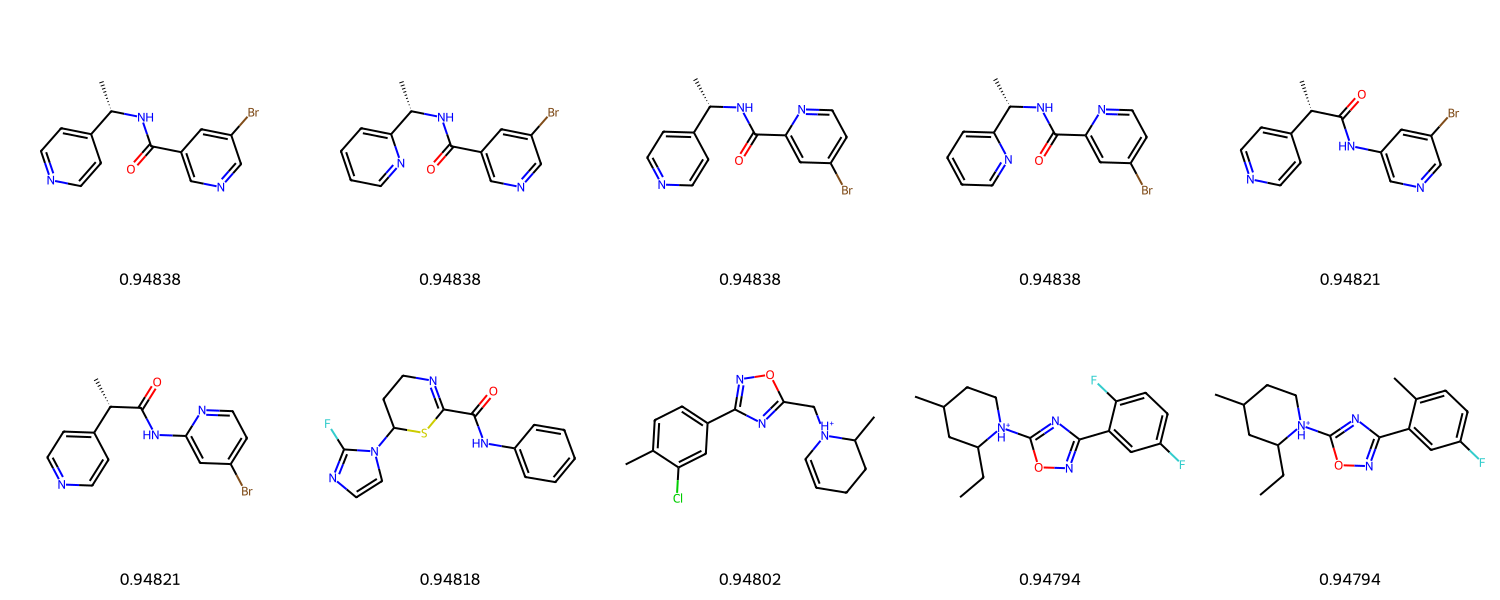

In [32]:
top_n_molecs = [Chem.MolFromSmiles(smiles[1]) for smiles in list(sorted(ga_results.population,reverse=True)[:10])]
top_n_scores = [str(round(smiles[0],5)) for smiles in list(sorted(ga_results.population,reverse=True)[:10])]

img = Draw.MolsToGridImage(top_n_molecs, molsPerRow=5, subImgSize=(300, 300), legends=top_n_scores)
img

In [7]:
!pip install molfeat

In [13]:


fp_transformer = FPVecTransformer(kind="ecfp:4", length=2048)
features = fp_transformer(mol_libraries.random_zinc(1000))

In [14]:
with open("/content/rf_regressor(2).pkl", "rb") as fin:
    fp_trans, loaded_RF_model = pkl.load(fin)

In [19]:
transformed_new_data = fp_trans.transform([smiles[1] for smiles in sorted(ga_results.population,reverse=True)])

In [16]:
predictions = loaded_RF_model.predict(transformed_new_data)
len(predictions)

9565

In [38]:
top_n_rf_scores = [str(round(x,4)) for x in list(predictions[:10])]

In [35]:
top_n_rf_scores

['5.665400000000001',
 '5.2487499999999985',
 '5.6007',
 '5.291999999999999',
 '5.6413',
 '5.464300000000001',
 '5.7191',
 '5.644200000000001',
 '5.675300000000001',
 '5.818800000000002']

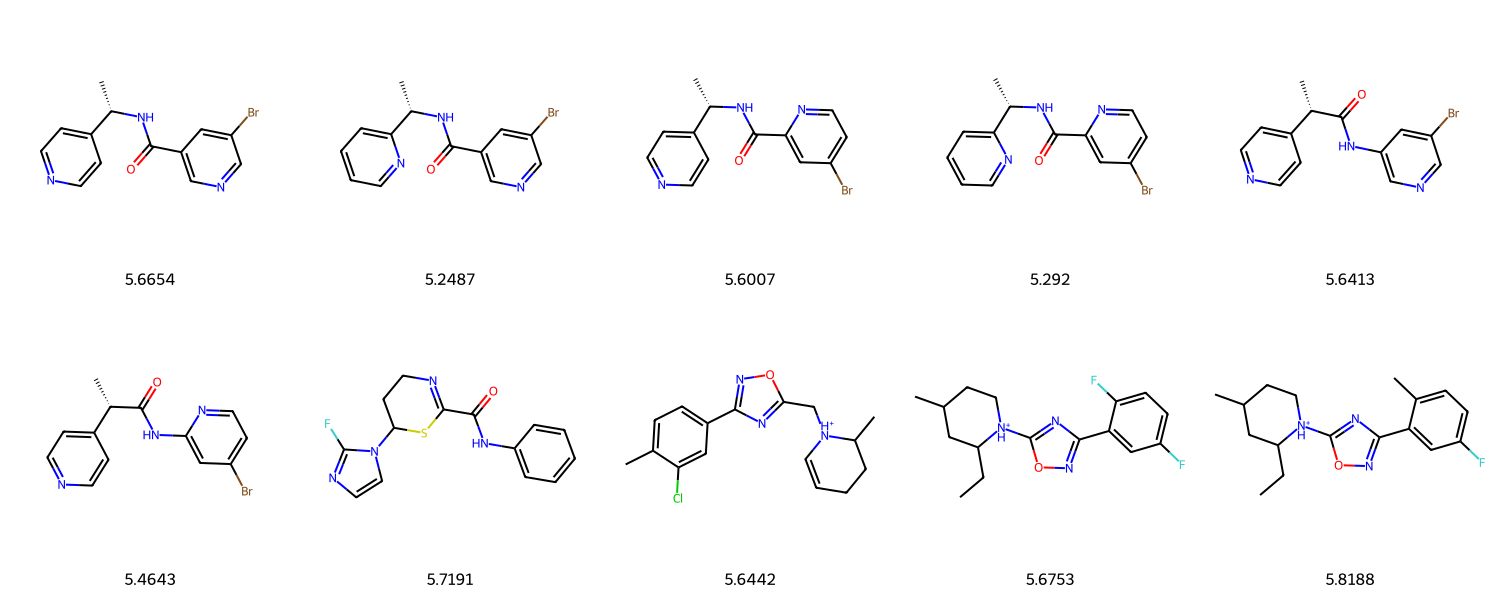

In [39]:
img = Draw.MolsToGridImage(top_n_molecs, molsPerRow=5, subImgSize=(300, 300), legends=top_n_rf_scores)
img